<img src="imgs/header.png" width="100%">

---------------

# Unit III: Probabilistic filtering
#### Inferring user intention in a noisy world
<b>[John Williamson](http://johnhw.com)</b> 

----

    All theorems are true. 
    All models are wrong. 
    And all data are inaccurate. 

    What are we to do? 
    We must be sure to remain uncertain.

-- *[Leonard A. Smith, Proc. International School of Physics ``Enrico Fermi", (1997)](http://www2.maths.ox.ac.uk/~lenny/fermi96_main_abs.html)* 

# Introduction 

-----------------
### What are we going to do?
We will:
* show how to represent interaction problems as inference;
* discuss how probabilistic filters can be used to attack these inference problems;
* specifically show how motion-based interfaces can use probabilistic filtering to increase robustness.


### What will we *practically* do?
* We will build a 2D mouse gesture recognizer using a hybrid discrete/continuous particle filter. This will be a simple, robust classifier with rich feedback opportunities.

<img  src="imgs/capture.png" width="80%"/>



------

#### What is probabilistic filtering ?
One view on interaction is to see user intentions as **unknown values** which are partially observed through input sensors. The time series of inputs from the user only give a partial, noisy, incomplete view of intention inside the user's head. 

Probabilistic filtering **(PF)** tracks the evolution of some unknown variables *[user intentions]* given observed evidence *[user input]*, in a way that is **robust**. Probabilistic filters infer a **distribution** over possible hidden (unobserved) variables, updating them over time. These filters are inherently **uncertain**, as they represent degrees of belief, and **dynamic**, as they explicitly model changing state over time.

<img src="imgs/brain_inference.png">

#### Simulation viewpoint
These filters are really *simulators*. They *simulate* how possible user behaviors might unfold over time. In some probabilistic filters, hundreds of parallel simulators are run, each with slightly different parameters. In all cases, the simulations are adjusted online to better match observed reality. The internal parameters that drive the simulation are the *unknown variables* we want to infer and the *evidence* is the observed reality that adjusts the simulation parameters.

#### Properties
Probabilistic filtering is:

| Property | Why  |
|----------|------|
|**Bayesian**  |  Represents degrees of belief using probability distributions.    |
|**predictive**  |  Works by comparing predictions with reality.   |
|**generative** |  Involves generating (i.e. simulating) behavior.   |

-----
Probabilistic filtering is an **inverse probability** approach, and it requires that we think of interaction from an unique perspective. We have to explicitly be able to write down:

* what we want to know (i.e. the **state space of intention**);
* how that will change over time (i.e. the **dynamics of intention**);
*  a model that *if we knew what the user intention was, what the expected behavior would be* (i.e. a **generative function mapping intention -> expected user inputs**).

Note that this last point is the **inverse** of the typical way of approaching this problem, where we would try and find a mapping from a sensors to intention, by design or by learning. 

### Why is this computational HCI?
Probabilistic filtering means writing down an **executable, statistical model** of user behavior, then **running an inference algorithm** that updates beliefs based on the way observations evolve. The **parameters** of the filter can be **learned from user data**. The effectiveness of the filter can be quantitatively measured.

### What are competitive approaches?
#### **Crafted mappings**
**where we try to find (by hand) transforms from sensors to intentions that are  simple or obvious.**

**Example:** a button, which has two physical states, and maps on to two intentional states via two electrical states. Pushed down = current flows = user intended to switch on. The mapping from electrical states to intentional states is **designed.**
<img src="imgs/undo.jpg">
*[Image credit: David Singleton via flickr.com CC-BY 2.0]*

#### **Machine learned mappings**
**where we train a system to recognize a class of input patterns as being representative of an intended behavior. **
**Example:** Finger gesture recognizer; hundreds of examples of many users performing one of N multi-touch gestures are recorded. These are used to train a random forest to classify the intended gesture. The mapping from electrical states (capacitive sensors) to intentional states is **learned**.

<img src="imgs/svm.jpg" width="300px">
*[Image credit: Elisfm - via Wikimedia Commons; public domain]*

### Benefits
* **Robustness to noise** PFs work well even with input sensors that are noisy.
* **Robustness to poorly specified models** PFs can cope predictably even if our models are bad.
* **Robustness to intermittence** PFs can continue to sensibly interpolate when input cuts out.
* **Uncertainty estimates** PFs *know how certain they are* and this can be used in the interaction design.
* **Decoupled from real-time** PFs can infer past (smoothing), present (filtering) and future (forecasting).
* **Inherent fusion of multiple input sensors** PFs are often used to solely to fuse together multiple inputs from different sensors.
* **Better feedback** PFs  offer the opportunity to give users rich insight into the process of intention decoding.
* **Flexible modeling** PFs can incorporate both fundamental modeling (e.g. physiological or cognitive models) and data-driven machine learning.

# Principles 
-------

> Interaction is the process of driving a system into a state compatible with user intentions.

There are many perspectives on interaction from this stance, including:

| Perspective   | Burden | Characteristic                         |
|---------------|--------|----------------------------------------|
| Communication | User   | User gets information into the system, by encoding intentions. |
| Control       | Split  | User drives state towards intention via feedback control.   |
| Inference     | System | System infers what user intention is from sensed user actions. |

### Interaction as inference
If we view interaction as inference of intention, there are three elements:
* **Interaction is inference**; it is the process of inferring a hidden variable: what the user wants a system to do. 
* **Observations are noisy and incomplete** What a system sees is a distorted and incomplete representation of user actions in the world, which are in turn a noisy representation of internal intentions (your hand does not always go where you want it...)
* **Interaction occurs over time** Interaction is a *process* that evolves over time. Information flow is not instantaneous.

<img src="imgs/brainspace.png" width="100%">

### Overview diagram



<img src="imgs/control_loop.png">



Notation:
* We have a sequence of states over time, indexed by $t$
* $X_t$ the variable we want to know (at time $t$) (e.g. an intention inside a user's head). 
* $Y_t$ the variable we can observe (e.g. a sensor we can get readings from).
* For computational simplicity, we assume **discrete time**, i.e. we observe sensors in a discrete, regularly sampled way.

* We want to compute $P(X_t|Y_t)$ (the **inverse problem**). 
* We use a **forward model** $P(Y_t|X_t)$ to infer this.
* We need to define two functions: ${\bf\hat{y_t}} = f({\bf \hat{x}}_t)$ (the **observation function**) and $\hat{\bf x}_{t} = g(\hat{\bf x}_{t-1})$ (the **dynamics** or **process function**).
* We also need a **weighting function** $w(\bf\hat{y_t},{\bf y_t})$ that computes how similar a simulated observation $\bf\hat{y_t}$ is to the real observation $\bf y_t$. This is used to compute the likelihood $p(\bf\hat{y_t}|{\bf y_t})$.

* $f$, $g$ and $w$ are often very simple functions.

<img src="imgs/stochastic.png" width="75%">

#### Predictor-corrector
**This is a predictor-corrector model**; the dynamics model supplies predictions, and corrections to those predictions are applied by the observation model.


### Problem description
We are going to solve a simple problem:

* Recognising simple 2D gestures, drawn with a mouse.

This is readily solved with "standard" (inverse) algorithms, but we will show how a model-led approach lets us encode our assumptions elegantly **and** we get all the benefits of *probabilistic* tracking. We'll see how probabilistic filters degrade gracefully when our models are bad or measurements are noisy.

#### Algorithm
We will use the **particle filter** algorithm (technically the **SIR** variant, which is the simplest to understand).

A particle filter requires that we specify:
* A **dynamics function** that predicts how we expect the world to evolve, which takes 
$\hat{\bf{x}}_t \rightarrow \hat{\bf x}_{t+1}$
* An **observation function** that predicts what we expect to observe, given a hypothesized state $\hat{\bf y}_t \rightarrow \hat{\bf{x}_t}$
* A **weight function**, that, given a hypothesized observation $\hat{\bf y}_t$, can be used to compute $p(\hat{\bf y}_t|{\bf y}_t)$. This is performed by computing weights $w_i$ for each particle $i$ and then normalizing to produce a probability:
$$p^{(i)}(\hat{\bf y}_t|{\bf y}_t) = \frac{w_i}{\sum_j w_j}$$
* A set of **prior distributions** that specify our initial guesses for $\hat{\bf x}_t$

### Basic filtering
We will first implement a basic particle filter that can track a very simple one dimensional time series. This toy problem is easy to understand and work with.

Then, we will show how this can generalise to an interesting HCI problem.

In [1]:
# import the things we need
from __future__ import print_function, division
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pykalman, pfilter
import ipywidgets
import IPython
import matplotlib, matplotlib.colors
matplotlib.rcParams['figure.figsize'] = (14.0, 8.0)
%matplotlib inline
from scipy.stats import norm

### Some test data
To test the particle filter, we will try and track a very simple, 1D sine wave:
$$Y_t=\sin(t)$$

This is a simple, smooth process.
We will try and estimate our "hidden" value $\bf{X}$ via an observed variable $\bf{Y}$ which is just $\bf X$ with some noise added.

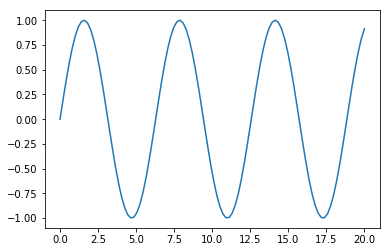

In [2]:
t = np.linspace(0,20,100).reshape(-1,1)
x = np.sin(t)
plt.plot(t,x)

### Simple model
We will use a very simple model

* **Dynamics**
We assume that there are no predictable dynamics, just some Gaussian noise $X_t = X_{t+1} + \epsilon,\  \epsilon \sim N(0,\sigma_p)$

In [3]:
sigma_p = 0.2              # the process noise 
beta = 0.25                # the RBF width
simulated_noise = -2     # the simulated noise we added

In [4]:
### Identity Example
def dynamics(x):
    # tomorrow is the same as today
    # but slightly randomly different
    # we literally *add* noise to our previous state
    return x+np.random.normal(0,sigma_p,x.shape)

We can show what this dynamics model looks like, if we had no resampling step in the filter. This makes predictions without ever having seen any data.

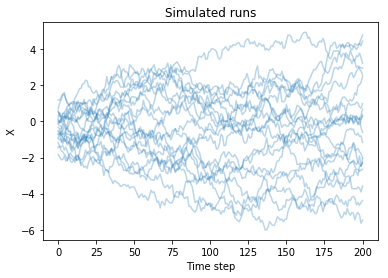

In [5]:
def simulate_dynamics(priors, dynamics, steps, n_runs=1):
    runs = []
    def simulate_run():
        x = np.array([p.rvs() for p in priors])
        xs = [x]    
        for i in range(steps):
            x = dynamics(x)
            xs.append(x)
        return xs    
    return np.array([simulate_run() for j in range(n_runs)])
    
simulated = simulate_dynamics(priors=[norm(0,1)], dynamics=dynamics, steps=200, n_runs=20)   
plt.plot(simulated[:,:,0].T, alpha=0.3, c='C0');
plt.xlabel("Time step")
plt.ylabel("X")
plt.title("Simulated runs")

* **Observation**
We assume that the sensor we measure is the value we want to infer, i.e. $Y_t=X_t$, and $g(X_t)$  is just the identity.

In [6]:
def observe(x):
    # we observe x directly
    return x[:,0]

* **Weighting**
We weight samples according to how similar they are to the observed output. We use a simple **heat kernel**:
$$w_i = e^{\left(-\frac{(y-y^\prime)^2}{2\beta^2}\right)}$$
$\beta$ is a parameter that lets us specify how precise our matching between observation and reality is.

Note that this gives more weight to particles that are more similar to the observation: it is a **similarity** function, not a distance function.

In [7]:
def weight(true_y, hypothesized_y):
    # RBF similarity function    
    return np.exp(-np.sum((true_y-hypothesized_y)**2, axis=0)/(0.5*beta**2))

We can see what this function looks like, comparing a true value of 0 with values in [-1, 1], $\beta=0.25$:

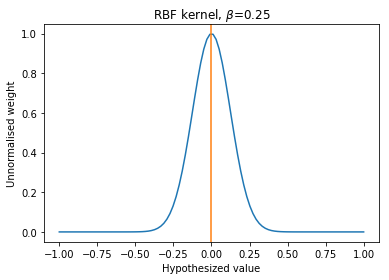

In [8]:
hypo = np.linspace(-1,1,100).reshape(1,100)
plt.plot(hypo.reshape(100,), weight(0, hypo))
plt.axvline(0,c='C1')
plt.xlabel("Hypothesized value")
plt.ylabel("Unnormalised weight")
plt.title("RBF kernel, $\\beta$=0.25")

**Priors**
We assume a very simple prior on $X$; that it is normally distributed, mean 0, variance 1, $X_0 \sim N(0,1)$

In [9]:
# we assume that, before seeing any evidence, that the particles are 
# normally distributed about 0, with std. dev. 1.0
prior = [norm(0,1)] # x ~ N(0,1)

## Filter creation

In [10]:
pf_simple = pfilter.ParticleFilter(initial=prior, 
                                    observe_fn=observe,
                                    n_particles=200,                                    
                                    dynamics_fn=dynamics,
                                    weight_fn=weight,                    
                                    resample_proportion=0.02)

In [11]:
def run_pfilter(pfilter, inputs):
    """Apply a particle filter to a time series of inputs,
    and return the particles, their weights, and the mean
    estimated state"""    
    # reset filter
    pfilter.init_filter()
    particles = []
    weights = []
    means = []    
    # apply to each element of the time series
    for i in range(len(inputs)):    
        pfilter.update([inputs[i]])
        particles.append(pfilter.particles)    
        weights.append(pfilter.weights)
        means.append(pfilter.mean_state)        
    return np.array(particles), np.array(weights), np.array(means)

We define a utility function to plot the results of running a particle filter:

In [12]:
def plot_pfilter(time,expected, observed, particles, weights, means):
    """Apply a particle filter to a time series, and plot the
    first component of the predictions alongside the expected
    output."""
    # expected output
    plt.plot(time, expected, 'C1', lw=3)
    plt.plot(time, observed, '+C3', lw=3)
    
    # particles 
    ts = np.tile(time[:,None], particles.shape[1]).ravel()
    weights =  weights.ravel()    
    rgba_colors = np.zeros((len(weights),4))
    rgba_colors[:,0:3] = matplotlib.colors.to_rgb('C2')
    weights *= 10
    rgba_colors[:, 3] = np.clip(weights, 0, 1)
    plt.scatter(ts, particles[:,:,0].ravel(),  c=rgba_colors, s=2)
    # mean estimation
    plt.plot(time, means, 'C0--', lw=2)
    # legend
    plt.legend(["True", "Observed", "Mean estimate", "Particle"])
    plt.xlabel("Time")
    plt.ylabel("X")
    plt.title("Particle filter estimate")
  

## Running the estimator

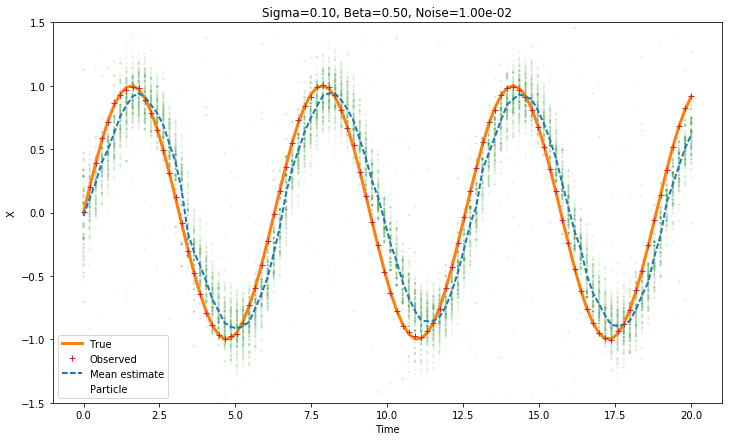

In [13]:
def run_filter(sig=0.1, bet=0.5, noise=-2):
    global sigma_p, beta, noise_level
    sigma_p = sig
    beta = bet
    noise_level = 10**noise
    noise = np.random.normal(0,noise_level, x.shape)
    plt.figure(figsize=(12,7))
    y = x + noise
    particles, weights, means = run_pfilter(pf_simple, y)
    plot_pfilter(t, x, y, particles, weights, means)
    plt.title("Sigma=%.2f, Beta=%.2f, Noise=%.2e" % (sigma_p, beta, noise_level))
    plt.ylim(-1.5, 1.5)
    
run_filter(sig=0.1, bet=0.5, noise=-2)

Let's adjust these interactively

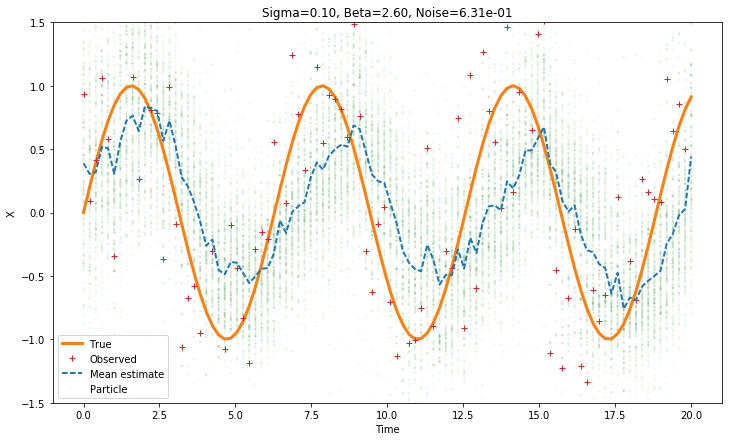

In [14]:
ipywidgets.interact_manual(run_filter, sig=(0.0, 2, 0.05), bet=(0.1, 5.0, 0.1), noise = (-5.0, 1.0, 0.1))

#### Things to note
* This is a trivial model, but still tracks "complex" functions, because it is adapting to observations
* Things to adjust:
    * noise level
    * rbf width beta
    * dynamics noise sigma



## A more interesting example
Imagine we wanted to infer the **phase** of the oscillator driving this sine wave. The phase variable is not observable, but we can  infer it from the observed oscillation. Furthermore, we want the *unwrapped* phase, i.e. we expect the phase to monotonically increase.

<img src="imgs/phase.gif">
*[Image credit:1ucasvb]*

We can encode these assumptions in our model, then see if the particle filter is able to infer the hidden parameter over time.

* **Observation**
We postulate an observation model:
$$Y_t = \sin(X_t)$$
i.e. that what we see is the effect of sine on a hidden variable $X_t$.
Because we defined $Y_t=\sin(t)$, we are actually trying to infer $t$.

* **Dynamics**
We assume that we have a very simple dynamical system in discrete time, where we have a velocity and a position.
$$X_t = \begin{bmatrix}x \\ \dot{x}\end{bmatrix},$$ and 
$$X_{t+1} = X_t + \begin{bmatrix}\dot{x} \\ 0 \end{bmatrix}.$$

This means that if we start linearly increasing or decreasing at a certain rate, we should expect to keep doing so.

* **Priors**
We again assume that the initial distribution is normally distributed.


In [15]:
### Example
sigma_x = 0.1
sigma_dx = 0.001

def linear_dynamics(x):        
    nx = np.dot(x,np.array([[1,0],
                            [1,1]]))        
    process_sigmas = [sigma_x, sigma_dx] # how much noise for x and dx    
    nx += np.random.normal(0,process_sigmas,x.shape)
    return nx

def observe_sin(x):    
    # y = sin(x)    
    return np.sin(x[:,0])

def weight_sin(true_y, hypothesized_y):    
    return np.exp(-np.sum((true_y-hypothesized_y)**2, axis=0)/beta)
    
from scipy.stats import norm
prior = [norm(0,1), norm(0,0.25)] 

pf_sin = pfilter.ParticleFilter(initial=prior, 
                                observe_fn=observe_sin,
                                n_particles=200,
                                dynamics_fn=linear_dynamics,
                                weight_fn=weight_sin,                    
                                resample_proportion=0.01)

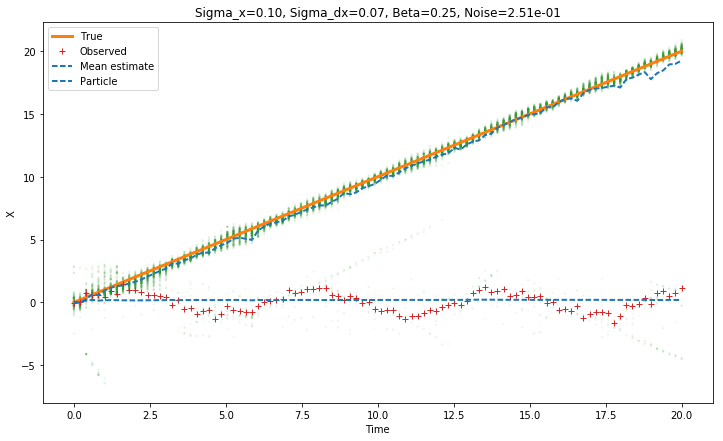

In [16]:

def run_sinfilter(sig_x=0.1, sig_dx=0.01, bet=0.25, noise=-2):
    global sigma_p, beta, noise_level
    sigma_x = sig_x
    sigma_dx = sig_dx
    beta = bet
    noise_level = 10**noise
    noise = np.random.normal(0,noise_level, x.shape)
    plt.figure(figsize=(12,7))
    y = x + noise
    particles, weights, means = run_pfilter(pf_sin, y)
    plot_pfilter(t, t, y, particles, weights, means)
    plt.title("Sigma_x=%.2f, Sigma_dx=%.2f, Beta=%.2f, Noise=%.2e" % (sigma_x, sigma_dx, beta, noise_level))
    
ipywidgets.interact_manual(run_sinfilter, sig_x=(0.0, 2, 0.05), sig_dx=(0.0, 0.5, 0.01), 
                           bet=(0.1, 5.0, 0.1), noise = (-5.0, 1.0, 0.1))    




#### Things to note
* The particle filter was able to infer the hidden state, despite only having a forward model (i.e knowledge of $\sin(x)$, **not** $\sin^{-1}(x)$)
* It correctly unwrapped phase, because we primed it with the dynamics model to expect values that would increase at a linear rate.
* This problem results in *multimodal* distributions, because there are an infinite number of solutions to $y=sin(x)$ because we can add any multiple of $2\pi$ without changing anything.
We can see these as fainter lines on the particle plot.
* This means that the particle mean is not actually a good estimate in this case! A better choice might be the most likely particle -- the Maximum A Posteriori (MAP) estimate.

## Example: Gesture recognition
Lets now apply these ideas to a practical HCI task: recognising 2D gestures.

We will base our algorithm directly on the one given in [A Probabilistic Framework for Matching
Temporal Trajectories](http://www.cs.toronto.edu/~jepson/papers/BlackJepsonECCV1998.pdf).

## Data
We have some example data with a few example 2D mouse-drawn gestures. Here we are assuming just a **single** template for each gesture, for simplicity.

In [24]:
import gestures
gestures = reload(gestures)
g = gestures.GestureData("gestures.txt")

## Gesture shapes 
We can plot the shapes of the gesture trajectories.

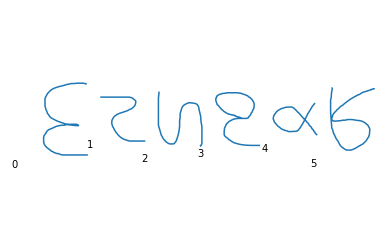

In [25]:
n_gestures = g.n_gestures
for i in range(n_gestures):
    plt.subplot(1, n_gestures,i+1)
    path = g.gestures[i]    
    plt.plot(path[:,0], path[:,1])
    plt.text(0,0,"%d"%i)
    plt.axis("off")
    plt.axis("equal")
    

## Timeseries view
We can also see each gesture as a trajectory of two coordinates ($x,y$ coordinates) over time. This is closer to the way in which the matching will work.

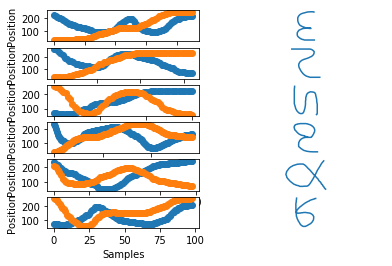

In [23]:
plt.figure()
for i in range(n_gestures):
    plt.subplot(n_gestures,2,i*2+1)    
    path = g.gestures[i]    
    plt.plot(path[:,0], 'oC0')
    plt.plot(path[:,0], '-C0')
    plt.plot(path[:,1], 'oC1')
    plt.plot(path[:,1], '-C1')
    plt.xlabel("Samples")
    plt.ylabel("Position")    
    plt.subplot(n_gestures,2,i*2+2)
    plt.plot(path[:,0], path[:,1], 'C0')
    plt.axis("equal")
    plt.axis("off")

### Problem
We want to recognize 2D gestures drawn with a mouse (or finger/stylus). 
* We *observe* sequences of $x,y$ coordinates over time.
* We have some example templates for particular shapes that we want to match (e.g. letters)
* We don't know:
    * where the user will start drawing a gesture
    * how big the gesture will be    
    * how fast the user will draw the gesture (it may well be drawn at a non-constant speed)
* We want to be able to identify:  
    * which gesture the user is performing, if any
    * when the user has finished doing the gesture
    
#### Probabilistic view
Putting this into the probabilistic framework, we want to infer a probability distribution over gesture classes and gesture completion state, given a time series of $x,y$ coordinates. The $x,y$ points form our observation vector $Y$.

We assume gesture reproduction is in some way a "noisy reproduction" of the ideal template form, where there are various types of distortion that can be encountered.

#### Markov approximation
We could look at the whole time series of $x,y$ points and try and classify that. However, there are two problems:
* What is the "whole" time series -- i.e. how do we segment the gesture?
* We would have to store the entire series and somehow match it against templates.

A simple way to eliminate these problems is to rewrite the recognizer so that it depends on nothing but its immediately previous state; i.e. so that it satisfies the Markov property.

To do this, we need to introduce additional variables into the state we are estimating; but with judicious choice these can be a very small number of additional variables. In particular, we can just track how far along a gesture we are (the "phase") and update that over time. 

### Parameters
We are now in a position to write down a model for our gesture recognizer.

### State
First of all, the state we are trying to infer:

<img src="imgs/gesture.png">

$$X = [i,s,x_c,y_c,\theta,\phi,\dot{\phi}]$$

We have one of $n$ possible gestures
* $i$ the number of the gesture

Our model says a gesture will be identical to the template for that class of gesture, but might vary in:
* $s$ overall scale, within some tolerance
* $x_c,y_c$ center position (could be anywhere on screen)
* $\theta$ small changes in rotation (e.g. $<45^o$)

We must take note that what we observe is a position at a **single time point** in a gesture. This means we must estimate how far through a gesture we are.
* $\phi$ the proportion of gesture complete, in the fraction [0,1].
* $\dot{\phi}$ the rate at which the gesture is being performed (i.e. fast or slow).


#### Observation

* Given a gesture $i$, we have a template $G_i(\phi)$, which is returns an $x,y$ point for any value of $\phi$.

* We expect to observe $\hat{{\bf y}}=AG_i(\phi)$, where $A$ is a transformation matrix applying the translation $x_c,y_c$, the scaling $s$ and the rotation $\theta$.

#### Dynamics
We then specify some simple dynamics. These all allow the values to slowly change over time (i.e. some random drift), except for the phase $\phi$ which we also expect to steadily increase at the rate $\dot{\phi}$.

Specifically:
* $s_{t+1} = s_{t} + \sigma_s$ scale can drift slowly
* $x_{t+1} = x_{t} + \sigma_x$ position can drift slowly
* $y_{t+1} = y_{t} + \sigma_y$ position can drift slowly
* $\theta_{t+1} = \theta_{t} + \sigma_\theta$ orientation can drift slowly
* $i_{t+1}=i_{t}$  gesture class never changes
* $\phi_{t+1} = \phi_{t} + \dot{\phi}_{t} + \sigma_y$ progress is steady, with some drift
* $\dot{\phi}_{t+1} = \dot{\phi}_{t} + \sigma_y$ progress rate can drift

#### Priors
We then define our initial guesses for the state of the system, encoded as prior probability distributions.

* $s_0$ $N(1,0.25)$, should be around original size, with some latitude
* $x_0,y_0$ $U(0,\text{max_screen_size})$, could be anywhere on screen
* $\theta_0$ $N(0,15)$, angle will be close to original, with std. dev. of ~15 degrees
* $\phi_0$ $N(0,0.1)$, gestures will begin close to their start
* $\dot{\phi}_0$ N($\mu_{\dot{\phi}}, \sigma_{\dot{\phi}})$), gesture speeds will be distributed according to the observed speeds from the template
* $i_0$ discrete $U(0,n-1)$, could be any gesture

### Weighting function
We again use the simple heat kernel (or RBF):
$$w_i = e^{\left(-\frac{(y-y^\prime)^2}{2\beta^2}\right)}$$
(the specific choice of weighting  function is rarely very important, except if there are particularly unusual states to be compared)


### Code

### Pitfalls
Particle filter in particular can be tricky to tune. 

* As the state space expands (i.e. the number of variables tracked), the number of particles requires can increase. This makes it difficult to run filters efficiently in problems that have lots of degrees of freedom.




# Outlook
---------------------
### Scope and limitations
#### Scope
* Probabilistic filters can be applied to many problems in HCI. Typically, if a process unfolds over time and there is uncertainty, a probabilistic filter is a strong candidate for inference. 

* The fact that inference is performed over time is a potential advantage over "static" classification approaches, as feedback can be generated on the fly, instead only after completion of an action. 

* In the specific context of gestures, the ability to infer the start and end-point of gestures can solve the "segmentation problem" or "gesture spotting problem" that is often awkward and leads to kludges like button presses to segment actions.

* Probabilistic motion models can easily be linked to higher-order probabilistic models which infer long-term actions on the part of the user. Because everything is a probability distribution, there is a simple common basis for integrating such models. This, for example, can include language models which estimate a distribution over text that is likely to be entered given both user input and a statistical model of language.

#### Limitations
* PFs can be computationally intensive to run. 
* Curse-of-dimensionality can make the attractive simplicity of PFs work poorly in practice as the state space expands (although often better than you might expect).
* Sometimes the inverse probability model can be hard to formulate. Conversely, it is sometimes very much easier.
* Particle filters are simple and elegant, but inferentially weak.
* Kalman filters are rigid and restrictive, but very inferentially efficient.
* Hybrid approaches (Ensemble Kalman filter, Unscented Kalman Filter, hybrid particle/Kalman filters, Rao-Blackwellized filters) can trade these qualities off, but they aren't off the shelf solutions (i.e. you need an expert!).


### Resources
#### Basic
* Read the [Condensation paper](http://vision.stanford.edu/teaching/cs231b_spring1415/papers/isard-blake-98.pdf).
* Read [the Kalman filter in pictures](http://www.bzarg.com/p/how-a-kalman-filter-works-in-pictures/)
* Watch [the particle filter without equations](https://www.youtube.com/watch?v=aUkBa1zMKv4)

#### Advanced
* [A technical but succinct and clear explanation of the particle filter](http://www.cns.nyu.edu/~eorhan/notes/particle-filtering.pdf)
* [A bibliography of particle filter papers](http://www.stats.ox.ac.uk/~doucet/smc_resources.html)



------
### Future of probabilistic filtering

#### Learned models

Much use of probabilistic filters has depended on strong mathematical models of the fundamental process. For example, in rocket science, sophisticated physics models were used to specify the Kalman filters used for stable control. 

However, it is becoming increasingly possible to **infer** these models from observations. Techniques such as deep learning (for example variational autoencoders or generative adversarial networks) make it possible to learn very sophisticated *generative models* from observations of
data.  These models can be dropped into probabilistic filters to produce robust inferential engines for user interaction.

##### Example
As an illustrative example, we recently built a touch pose estimator to estimate the pose of a finger from a capacitive sensor array (as found on a touch screen). We trained DCNN to predict finger pose from sensor images (inverse model), a separate deconvolutional CNN to predict sensor images from finger poses (forward model) and then fused these using a particle filter.

<img src="imgs/fwd_inv.png">
This combined gives substantial robustness, and we were able to introduce a simple dynamics model, which filters out completely implausible movements.

